## 第十週：主題模型（中文）
Last modified: 蔡睿澤（2024/04/23） <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為7個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

In [97]:
udn = pd.read_csv("raw_data/udn.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,湯普森樂於接受替補地位 或許是長留勇士的生存之道,3/1/2024 7:00,運動,https://udn.com/news/story/122629/7801017,湯普森(Klay Tompson)近期連續五場球被勇士教練團降為替補，這也是他打從新人年以來...,UDN
1,2,日職／大聯盟之夢想圓滿 村上宗隆近兩季須達成業績,3/4/2024 7:00,運動,https://udn.com/news/story/122629/7806019,剛打完台灣遠征比賽的讀賣巨人，返回日本之後準備迎接官辦熱身賽，為2024年例行賽之前做最後備...,UDN
2,3,洋基第一棒該派誰打？ 索托或許才是最佳人選,3/4/2024 7:00,運動,https://udn.com/news/story/122629/7806063,誰是洋基隊史上最偉大的開路先鋒？頭一個會想到的八成是「隊長」基特（Derek Jeter）。...,UDN


In [98]:
# 設定統一的類別字典
cat_dict = {
    '全球': '國際',
    '國際': '國際',
    '股市': '股市',
    '運動': '體育',
    '體育': '體育',
    '社會': '社會',
}

In [99]:
list(udn)

['system_id',
 'artTitle',
 'artDate',
 'artCatagory',
 'artUrl',
 'artContent',
 'dataSource']

In [100]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['artCatagory'] = udn['artCatagory'].map(cat_dict)
udn['content'] = udn['artContent']
udn = udn.dropna()


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,湯普森近期連續五場球被勇士教練團降為替補這也是他打從新人年以來首度從板凳出發據統計湯普森此前...,https://udn.com/news/story/122629/7801017,體育,3/1/2024 7:00
1,剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接官辦熱身賽為年例行賽之前做最後備戰巨人軍想要...,https://udn.com/news/story/122629/7806019,體育,3/4/2024 7:00
2,誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長基特不過基特其實是在年過的生涯第個球季...,https://udn.com/news/story/122629/7806063,體育,3/4/2024 7:00


In [101]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\week10\dict\dict.txt.big ...
2024-05-03 21:31:08,870 : DEBUG : Building prefix dict from c:\Users\USER\Desktop\final_scribble\SMA\week10\dict\dict.txt.big ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u0fc3dfc83dbb17ee16ee9a2894692f47.cache
2024-05-03 21:31:08,871 : DEBUG : Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u0fc3dfc83dbb17ee16ee9a2894692f47.cache
Loading model cost 0.813 seconds.
2024-05-03 21:31:09,684 : DEBUG : Loading model cost 0.813 seconds.
Prefix dict has been built successfully.
2024-05-03 21:31:09,685 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,湯普森近期連續五場球被勇士教練團降為替補這也是他打從新人年以來首度從板凳出發據統計湯普森此前...,https://udn.com/news/story/122629/7801017,體育,3/1/2024 7:00,"[湯普森, 近期, 連續, 五場, 勇士, 教練, 團降, 替補, 這也, 新人, 以來, ..."
1,剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接官辦熱身賽為年例行賽之前做最後備戰巨人軍想要...,https://udn.com/news/story/122629/7806019,體育,3/4/2024 7:00,"[剛打, 完台灣, 遠征, 比賽, 讀賣, 巨人, 返回, 日本, 之後, 準備, 迎接, ..."
2,誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長基特不過基特其實是在年過的生涯第個球季...,https://udn.com/news/story/122629/7806063,體育,3/4/2024 7:00,"[洋基隊, 史上, 偉大, 開路先鋒, 想到, 隊長, 基特, 基特, 年過, 生涯, 第個..."
3,近期媒體報導樂天桃猿教練團計畫將先發投手曾仁和轉調牛棚陳冠宇自請重回先發老實說這樣的安排風險...,https://udn.com/news/story/122629/7806105,體育,3/4/2024 7:00,"[近期, 媒體, 報導, 樂天, 桃猿, 教練, 團計, 畫將, 先發, 投手, 仁和, 轉..."
4,撰文石毓琪四年前職業棒球雜誌於球春到來開季春訓特輯封面放上時任隊總教練快轉個球季只剩下近年摘...,https://udn.com/news/story/122629/7808048,體育,3/6/2024 12:00,"[撰文, 石毓琪, 四年, 職業, 棒球, 雜誌, 球春, 到來, 開季, 春訓, 特輯, ..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [102]:
udn['artCatagory'].unique()

array(['體育', '國際', '社會', '股市'], dtype=object)

In [103]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == '體育',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['比賽', '台灣', '聯盟', '球隊', '巨人', '球員', '選手', '台北', '讀賣', '球迷', '日本', '兄弟',
       '賽事', '巨人隊', '大谷', '表現', '記者', '機會', '棒球', '投手', '希望', '教練', '拿下', '進行',
       '生涯', '啦啦隊', '時間', '攝影', '勇士', '戰績', '總教練', '球季', '運動', '中信', '籃板',
       '球場', '過去', '賽程', '樂天', '世界', '奧運', '訓練', '這次', '冠軍', '先發', '賽季', '參加',
       '球星', '對手', '紀錄', '國王', '領先', '熱身賽', '舉辦', '職棒', '主場', '春訓', '助攻', '狀況',
       '強賽', '期待', '成為', '試合', '獲得', '成績', '面對', '本季', '詹姆斯', '數據', '出賽', '未來',
       '國際', '加入', '美國', '這裡', '提供', '三分球', '中職', '完成', '開打', '取得', '交流', '東西',
       '挑戰', '包括', '門票', '擔任', '結束', '透露', '感覺', '攻下', '能夠', '應援', '直播', '全場',
       '幫助', '代表', '出現', '目標', '好手'],
      dtype='object')

In [104]:
global_cnt = udn.loc[udn['artCatagory'] == '國際',:]['words'].explode().value_counts().head(100)
global_cnt.index

Index(['美國', '拜登', '中國', '報導', '總統', '以色列', '國家', '日本', '公司', '川普', '經濟', '加薩',
       '政府', '美元', '認為', '市場', '支持', '包括', '烏克蘭', '進行', '宣布', '俄羅斯', '提供',
       '全球', '媒體', '官員', '巴勒斯坦', '影響', '問題', '共和黨', '戰爭', '哈瑪斯', '指數', '許多',
       '行動', '持續', '超過', '預期', '造成', '衝突', '增加', '英國', '安全', '國際', '物資', '台灣',
       '調查', '數據', '德國', '國會', '導致', '降息', '歐盟', '攻擊', '上漲', '地區', '報告', '選民',
       '希望', '援助', '億美元', '企業', '出現', '成長', '工作', '以來', '法案', '印度', '要求', '時間',
       '事件', '未來', '計畫', '初選', '組織', '南韓', '政策', '過去', '投資', '相關', '加薩走廊',
       '這項', '現在', '聯合國', '目標', '政治', '部分', '當地', '舉行', '透過', '受到', '法新社',
       '利率', '社群', '會議', '大陸', '合作', '成為', '引發', '人士'],
      dtype='object')

In [105]:
social_cnt = udn.loc[udn['artCatagory'] == '社會',:]['words'].explode().value_counts().head(100)
social_cnt.index

Index(['男子', '萬元', '記者', '分局', '毒品', '調查', '檢方', '駕駛', '認為', '造成', '員警', '公司',
       '翻攝', '派出所', '機車', '安全', '人員', '提供', '女子', '相關', '協助', '起訴', '法官',
       '新北市', '年月日', '貨車', '當時', '前往', '民眾', '地檢署', '偵辦', '法院', '警員', '車輛',
       '消防局', '檢察官', '台北', '到場', '分駐', '了解', '路口', '釐清', '涉嫌', '要求', '報案',
       '受傷', '家屬', '原因', '八堵', '送醫', '違反', '執行', '專線', '搜索', '桃園', '地院', '醫院',
       '移送', '生命', '上訴', '狀況', '台南', '衝撞', '文科', '案件', '台中市', '部分', '罪嫌', '接獲',
       '獲報', '工作', '立即', '新竹', '處理', '規定', '行為', '死亡', '審理', '開車', '台北市', '條例',
       '是否', '時分', '轎車', '攝影', '使用', '監視器', '基隆', '市長', '認定', '台南市', '對方',
       '疑似', '簡男', '政府', '行經', '附近', '偵查', '警察', '下午'],
      dtype='object')

In [106]:
stock_cnt = udn.loc[udn['artCatagory'] == '股市',:]['words'].explode().value_counts().head(100)
stock_cnt.index

Index(['億元', '營收', '市場', '成長', '持續', '台股', '指數', '投資', '表現', '公司', '獲利', '每股',
       '純益', '股價', '稅後', '需求', '第季', '股利', '預期', '上漲', '營運', '產品', '半導體', '產業',
       '新高', '台灣', '法人', '客戶', '現金', '投資人', '增加', '歷史', '股息', '合併', '全球', '相關',
       '帶動', '美國', '整體', '利率', '配發', '影響', '動能', '台積電', '展望', '伺服器', '業務',
       '累計', '公布', '外資', '昨日', '受惠', '預估', '漲幅', '盤中', '提升', '配息', '董事會', '未來',
       '訂單', '減少', '今日', '可望', '毛利率', '超過', '股票', '布局', '維持', '包括', '創新', '上市',
       '去年同期', '資金', '看好', '預計', '機會', '發展', '企業', '應用', '盈餘', '公告', '業績',
       '投信', '個股', '積電', '淨利', '產能', '電子', '優於', '買超', '族群', '市值', '年增', '科技',
       '降息', '大盤', '方面', '出貨', '資本', '台積'],
      dtype='object')

In [107]:
custom_topic_word = {
    "體育": [
       '比賽', '台灣', '聯盟', '球隊', '巨人', '球員', '選手', '台北', '讀賣', '球迷', '日本', '兄弟',
       '賽事', '巨人隊', '大谷', '表現', '記者', '機會', '棒球', '投手', '希望', '教練', '拿下', '進行',
       '生涯', '啦啦隊', '時間', '攝影', '勇士', '戰績', '總教練', '球季', '運動', '中信', '籃板',
       '球場', '過去', '賽程', '樂天', '世界', '奧運', '訓練', '這次', '冠軍', '先發', '賽季', '參加',
       '球星', '對手', '紀錄', '國王', '領先', '熱身賽', '舉辦', '職棒', '主場', '春訓', '助攻', '狀況',
       '強賽', '期待', '成為', '試合', '獲得', '成績', '面對', '本季', '詹姆斯', '數據', '出賽', '未來',
       '國際', '加入', '美國', '這裡', '提供', '三分球', '中職', '完成', '開打', '取得', '交流', '東西',
       '挑戰', '包括', '門票', '擔任', '結束', '透露', '感覺', '攻下', '能夠', '應援', '直播', '全場',
       '幫助', '代表', '出現', '目標', '好手', 
    ],
    "國際": [
       '美國', '拜登', '中國', '報導', '總統', '以色列', '國家', '日本', '公司', '川普', '經濟', '加薩',
       '政府', '美元', '認為', '市場', '支持', '包括', '烏克蘭', '進行', '宣布', '俄羅斯', '提供',
       '全球', '媒體', '官員', '巴勒斯坦', '影響', '問題', '共和黨', '戰爭', '哈瑪斯', '指數', '許多',
       '行動', '持續', '超過', '預期', '造成', '衝突', '增加', '英國', '安全', '國際', '物資', '台灣',
       '調查', '數據', '德國', '國會', '導致', '降息', '歐盟', '攻擊', '上漲', '地區', '報告', '選民',
       '希望', '援助', '億美元', '企業', '出現', '成長', '工作', '以來', '法案', '印度', '要求', '時間',
       '事件', '未來', '計畫', '初選', '組織', '南韓', '政策', '過去', '投資', '相關', '加薩走廊',
       '這項', '現在', '聯合國', '目標', '政治', '部分', '當地', '舉行', '透過', '受到', '法新社',
       '利率', '社群', '會議', '大陸', '合作', '成為', '引發', '人士',
    ],
    "社會": [
       '男子', '萬元', '記者', '分局', '毒品', '調查', '檢方', '駕駛', '認為', '造成', '員警', '公司',
       '翻攝', '派出所', '機車', '安全', '人員', '提供', '女子', '相關', '協助', '起訴', '法官',
       '新北市', '年月日', '貨車', '當時', '前往', '民眾', '地檢署', '偵辦', '法院', '警員', '車輛',
       '消防局', '檢察官', '台北', '到場', '分駐', '了解', '路口', '釐清', '涉嫌', '要求', '報案',
       '受傷', '家屬', '原因', '八堵', '送醫', '違反', '執行', '專線', '搜索', '桃園', '地院', '醫院',
       '移送', '生命', '上訴', '狀況', '台南', '衝撞', '文科', '案件', '台中市', '部分', '罪嫌', '接獲',
       '獲報', '工作', '立即', '新竹', '處理', '規定', '行為', '死亡', '審理', '開車', '台北市', '條例',
       '是否', '時分', '轎車', '攝影', '使用', '監視器', '基隆', '市長', '認定', '台南市', '對方',
       '疑似', '簡男', '政府', '行經', '附近', '偵查', '警察', '下午',
    ],
    "股市": [
       '億元', '營收', '市場', '成長', '持續', '台股', '指數', '投資', '表現', '公司', '獲利', '每股',
       '純益', '股價', '稅後', '需求', '第季', '股利', '預期', '上漲', '營運', '產品', '半導體', '產業',
       '新高', '台灣', '法人', '客戶', '現金', '投資人', '增加', '歷史', '股息', '合併', '全球', '相關',
       '帶動', '美國', '整體', '利率', '配發', '影響', '動能', '台積電', '展望', '伺服器', '業務',
       '累計', '公布', '外資', '昨日', '受惠', '預估', '漲幅', '盤中', '提升', '配息', '董事會', '未來',
       '訂單', '減少', '今日', '可望', '毛利率', '超過', '股票', '布局', '維持', '包括', '創新', '上市',
       '去年同期', '資金', '看好', '預計', '機會', '發展', '企業', '應用', '盈餘', '公告', '業績',
       '投信', '個股', '積電', '淨利', '產能', '電子', '優於', '買超', '族群', '市值', '年增', '科技',
       '降息', '大盤', '方面', '出貨', '資本', '台積',
    ],

}

In [108]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [109]:
vocabularies

array(['三分球', '上市', '上漲', '上訴', '下午', '世界', '中信', '中國', '中職', '主場', '了解',
       '事件', '交流', '人員', '人士', '今日', '代表', '以來', '以色列', '企業', '伺服器', '使用',
       '俄羅斯', '個股', '偵查', '偵辦', '億元', '億美元', '優於', '兄弟', '先發', '全場', '全球',
       '八堵', '公司', '公告', '公布', '共和黨', '冠軍', '出現', '出貨', '出賽', '分局', '分駐',
       '初選', '利率', '到場', '前往', '創新', '加入', '加薩', '加薩走廊', '助攻', '勇士', '動能',
       '包括', '半導體', '協助', '南韓', '印度', '原因', '去年同期', '參加', '取得', '受傷',
       '受到', '受惠', '可望', '台中市', '台北', '台北市', '台南', '台南市', '台灣', '台積',
       '台積電', '台股', '合作', '合併', '哈瑪斯', '員警', '問題', '啦啦隊', '國家', '國會',
       '國王', '國際', '地區', '地檢署', '地院', '執行', '基隆', '報告', '報導', '報案', '增加',
       '外資', '大盤', '大谷', '大陸', '奧運', '女子', '好手', '媒體', '安全', '完成', '官員',
       '客戶', '宣布', '家屬', '審理', '專線', '對手', '對方', '導致', '展望', '川普', '工作',
       '巨人', '巨人隊', '巴勒斯坦', '市值', '市場', '市長', '布局', '希望', '帶動', '幫助',
       '年增', '年月日', '引發', '強賽', '影響', '德國', '感覺', '應援', '應用', '成為', '成績',
       '成長', '戰爭', '戰績', '投信', '投手', '投資', '投資人', '拜登

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [110]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [111]:
udn_matrix.shape

(3928, 348)

In [112]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_體育,topic_國際,topic_社會,topic_股市
0,60,20,6,12
1,59,14,6,8
2,76,7,5,13
3,94,20,4,13
4,166,49,10,26
...,...,...,...,...
3923,2,7,2,30
3924,7,12,2,23
3925,5,23,3,46
3926,6,17,4,35


In [113]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_體育,topic_國際,topic_社會,topic_股市
0,0.612245,0.204082,0.061224,0.122449
1,0.678161,0.160920,0.068966,0.091954
2,0.752475,0.069307,0.049505,0.128713
3,0.717557,0.152672,0.030534,0.099237
4,0.661355,0.195219,0.039841,0.103586


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

In [114]:
# sklearn DTM
vocab = {'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

sample_docs = ["小美 喜歡 自然語言處理","小美 喜歡 文字分析"]
vectorizer = CountVectorizer(vocabulary=vocab)
dtm = vectorizer.fit_transform(sample_docs)
features = vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=features)
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


In [20]:
# for gensim
sample_docs2 =  [doc.split() for doc in sample_docs]
sample_docs2

[['小美', '喜歡', '自然語言處理'], ['小美', '喜歡', '文字分析']]

In [21]:
dct = Dictionary(sample_docs2)
print(dct)

2024-05-02 18:59:25,549 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-02 18:59:25,551 : INFO : built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)
2024-05-02 18:59:25,551 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)", 'datetime': '2024-05-02T18:59:25.551372', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']>


In [22]:
# 可以看到每個字都被 map 到一個特定的數字
dct.token2id

{'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

In [23]:
# BOW of gensim
print(sample_docs2[0])
dct.doc2bow(sample_docs2[0])

['小美', '喜歡', '自然語言處理']


[(0, 1), (1, 1), (2, 1)]

In [24]:
sample_corpus = [dct.doc2bow(doc) for doc in sample_docs2]
sample_corpus

[[(0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (3, 1)]]

In [25]:
# corpus 轉換成 DTM
dtm_c = corpus2dense(sample_corpus, num_terms=len(dct.token2id), num_docs=len(sample_corpus))
dtm_c

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [26]:
dtm_c.T

array([[1., 1., 1., 0.],
       [1., 1., 0., 1.]], dtype=float32)

In [27]:
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


**4.1 正式處理新聞**

In [115]:
docs = udn['words'].to_list()
docs[0]

['湯普森',
 '近期',
 '連續',
 '五場',
 '勇士',
 '教練',
 '團降',
 '替補',
 '這也',
 '新人',
 '以來',
 '首度',
 '板凳',
 '出發',
 '據統計',
 '湯普森',
 '此前',
 '連續',
 '以先',
 '發之姿',
 '出戰',
 '了場',
 '比賽',
 '聯盟',
 '僅次於',
 '德羅',
 '展里',
 '拉德',
 '柯瑞',
 '聯盟',
 '第四',
 '紀錄',
 '賽季',
 '湯普森',
 '來說',
 '十分',
 '掙扎',
 '招牌',
 '功力',
 '盡失',
 '拿手',
 '三分球',
 '整體',
 '投籃',
 '命中率',
 '雙雙',
 '寫下',
 '生涯',
 '新低',
 '場均',
 '得分',
 '優於',
 '生涯',
 '兩季',
 '要將',
 '過去',
 '奪冠',
 '功臣',
 '湯普森',
 '降為',
 '板凳',
 '球員',
 '主帥',
 '柯爾',
 '坦言',
 '這並',
 '容易',
 '作出',
 '決策',
 '事先',
 '湯普森',
 '溝通',
 '期待',
 '湯普森',
 '還做',
 '五六年',
 '柯爾',
 '受訪',
 '說道',
 '湯普森',
 '勇士',
 '核心',
 '唯一',
 '還沒',
 '獲得',
 '續約',
 '奪冠',
 '成員',
 '合約',
 '談判',
 '觸礁',
 '薪情',
 '不佳',
 '連帶',
 '影響',
 '心情',
 '場上',
 '表現',
 '最近',
 '看到',
 '發表',
 '奪冠',
 '老臣',
 '倚老賣老',
 '言論',
 '整個',
 '呈現',
 '浮躁',
 '表徵',
 '過去',
 '令人',
 '聞風喪膽',
 '勇士',
 '二當家',
 '勇士',
 '管理',
 '階層',
 '面對',
 '高額',
 '豪華',
 '稅的',
 '壓力',
 '湯普森',
 '巨額',
 '合約',
 '要求',
 '顯然',
 '球團',
 '保留',
 '態度',
 '觀望',
 '顧及',
 '多年',
 '深厚',
 '關係',
 '高層',
 '傾向',
 '投資',
 '球季',
 '破繭',
 

In [116]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-03 21:34:40,951 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-03 21:34:41,485 : INFO : built Dictionary<65800 unique tokens: ['一世', '一員', '一場', '一敗', '一環']...> from 3928 documents (total 699959 corpus positions)
2024-05-03 21:34:41,486 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<65800 unique tokens: ['一世', '一員', '一場', '一敗', '一環']...> from 3928 documents (total 699959 corpus positions)", 'datetime': '2024-05-03T21:34:41.486974', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-05-03 21:34:41,537 : INFO : discarding 51743 tokens: [('一世', 3), ('一敗', 2), ('二當家', 1), ('五六年', 1), ('五場', 4), ('令人尊敬', 2), ('以先', 1), ('倚老賣老', 1), ('光榮', 4), ('別件', 1)]...
2024-05-03 21:34:41,538 : INFO : keeping 14057 tokens which were in no less than 5 and no more than 3888 (=99.0%) documents
2024-05-03 21:34:41,562 : INFO : resulting dictionary:

Dictionary<14057 unique tokens: ['一員', '一場', '一環', '一直', '一股']...>


In [117]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一員: 0
一場: 1
一環: 2
一直: 3
一股: 4
三分球: 5
上半場: 6
上旬: 7
下一場: 8
下來: 9
不佳: 10
不足: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [118]:
pprint(" ".join(udn['words'].iloc[600]))


('俄羅斯 地方 官員 烏克蘭 出動 無人機 攻擊 邊界 附近 一座 俄羅斯 採礦 廠並 攻擊 一處 燃料 引發 大火 基輔 當局 宣布 數十架 俄羅斯 '
 '無人機 攔截 俄烏 雙方 發動 一波 夜間 空中 攻擊 行動 試圖 深入 敵人 後方 打擊目標 法新社 報導 俄羅斯 斯克州 州長 塔羅 沃特 今天上午 '
 '頻道 發布 影音 訊息 烏克蘭 再度 對庫 斯克州 發動 攻擊 無人機 攻擊 位於 列茲諾 戈爾斯 一處 燃料 潤滑油 倉庫 當地 現在 大火 塔羅 '
 '沃特 之後 第架 無人機 擊中 列茲諾 戈爾 斯克市 米哈伊 洛夫斯基 採礦 加工廠 倉庫 該廠 距離 烏克蘭 邊境 公里 俄羅斯 社群 媒體 流傳 '
 '影片 看到 圓柱型 燃料 儲存 槽內 大火 熊熊燃燒 濃煙滾滾 基輔 當局 指控 俄羅斯 烏克蘭 領土 發射 飛彈 派出 伊朗 設計 攻擊 無人機 發動 '
 '攻擊 造成 至少 受傷 烏克蘭 空軍 發表 明說 見證者 無人機 擊落 無人機 俄羅斯 邊界地區 俄國 併吞 克里米亞半島 起飛 烏克蘭 檢察長 東部 '
 '蘇米州 夜間 攻擊 造成 受傷 包括 男孩 蘇米州 州長 亞提 烏克 一架 無人機 攻擊 當地 一家 安置 病患 醫院 東北部 哈爾科夫 州州 檢察官 '
 '辦公室 該州 一所 學校 幼兒園 建築 受損 幸未 傳出 人員傷亡 南部 敖德薩 官員 當地 一座 休閒 中心 一條 天然氣 管線 住宅 大樓 擊落 '
 '無人機 碎片 波及 受損 赫梅利 尼茨基 部分 地區 攻擊 陷入 停電 俄羅斯 地方 官員 烏克蘭 邊界 貝爾 哥羅 德州 發射 出動 無人機 攻擊 '
 '貝爾 哥羅 德州 州長 造成 部份 輕微 損害 人員傷亡 俄羅斯國防部 俄軍 擊落 貝爾 哥羅 德州 佛洛 尼斯 上空 無人機 俄羅斯 總統 蒲亭 稍後 '
 '將和 國際 原子能 總署 署長 羅西 索契 會面 兩人將 討論 烏克蘭 波羅 熱核 電廠 情勢')


In [119]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(54, 2),
 (174, 1),
 (185, 1),
 (191, 1),
 (284, 1),
 (291, 1),
 (387, 3),
 (400, 1),
 (580, 1),
 (585, 1)]

In [120]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [121]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [122]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2024-05-03 21:34:58,072 : INFO : using symmetric alpha at 0.1
2024-05-03 21:34:58,073 : INFO : using symmetric eta at 0.1
2024-05-03 21:34:58,077 : INFO : using serial LDA version on this node
2024-05-03 21:34:58,092 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 3928 documents, updating model once every 2000 documents, evaluating perplexity every 3928 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-03 21:34:58,093 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-03 21:34:58,094 : INFO : PROGRESS: pass 0, at document #2000/3928
2024-05-03 21:34:58,859 : INFO : merging changes from 2000 documents into a model of 3928 documents
2024-05-03 21:34:58,867 : INFO : topic #1 (0.100): 0.006*"美國" + 0.004*"日本" + 0.003*"台灣" + 0.003*"聯盟" + 0.003*"報導" + 0.003*"以色列" + 0.002*"進行" + 0.002*"記者" + 0.002*"加薩" + 0.002*"造成"
2024-05-03 21:3

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [123]:
ldamodel.print_topics()

2024-05-03 21:35:04,767 : INFO : topic #0 (0.100): 0.014*"營收" + 0.006*"指數" + 0.006*"億元" + 0.005*"淨利" + 0.005*"獲利" + 0.004*"出貨" + 0.004*"市場" + 0.004*"公司" + 0.004*"第季" + 0.004*"毛利率"
2024-05-03 21:35:04,770 : INFO : topic #1 (0.100): 0.005*"男子" + 0.004*"記者" + 0.003*"毒品" + 0.003*"萬元" + 0.003*"認為" + 0.003*"員警" + 0.002*"調查" + 0.002*"檢方" + 0.002*"翻攝" + 0.002*"台灣"
2024-05-03 21:35:04,771 : INFO : topic #2 (0.100): 0.005*"成長" + 0.004*"美國" + 0.004*"億元" + 0.004*"天數" + 0.004*"營收" + 0.003*"台灣" + 0.003*"持續" + 0.003*"認為" + 0.003*"萬元" + 0.003*"指數"
2024-05-03 21:35:04,773 : INFO : topic #3 (0.100): 0.015*"股息" + 0.006*"萬元" + 0.004*"女子" + 0.003*"台灣" + 0.003*"人員" + 0.003*"公司" + 0.003*"機車" + 0.003*"美國" + 0.003*"消防局" + 0.003*"男子"
2024-05-03 21:35:04,774 : INFO : topic #4 (0.100): 0.008*"男子" + 0.006*"駕駛" + 0.005*"分局" + 0.004*"新北市" + 0.004*"記者" + 0.004*"萬元" + 0.004*"消防局" + 0.004*"造成" + 0.003*"翻攝" + 0.003*"億元"
2024-05-03 21:35:04,776 : INFO : topic #5 (0.100): 0.011*"億元" + 0.009*"市場" + 0.007*"成長" + 0.007*"公司" 

[(0,
  '0.014*"營收" + 0.006*"指數" + 0.006*"億元" + 0.005*"淨利" + 0.005*"獲利" + 0.004*"出貨" + 0.004*"市場" + 0.004*"公司" + 0.004*"第季" + 0.004*"毛利率"'),
 (1,
  '0.005*"男子" + 0.004*"記者" + 0.003*"毒品" + 0.003*"萬元" + 0.003*"認為" + 0.003*"員警" + 0.002*"調查" + 0.002*"檢方" + 0.002*"翻攝" + 0.002*"台灣"'),
 (2,
  '0.005*"成長" + 0.004*"美國" + 0.004*"億元" + 0.004*"天數" + 0.004*"營收" + 0.003*"台灣" + 0.003*"持續" + 0.003*"認為" + 0.003*"萬元" + 0.003*"指數"'),
 (3,
  '0.015*"股息" + 0.006*"萬元" + 0.004*"女子" + 0.003*"台灣" + 0.003*"人員" + 0.003*"公司" + 0.003*"機車" + 0.003*"美國" + 0.003*"消防局" + 0.003*"男子"'),
 (4,
  '0.008*"男子" + 0.006*"駕駛" + 0.005*"分局" + 0.004*"新北市" + 0.004*"記者" + 0.004*"萬元" + 0.004*"消防局" + 0.004*"造成" + 0.003*"翻攝" + 0.003*"億元"'),
 (5,
  '0.011*"億元" + 0.009*"市場" + 0.007*"成長" + 0.007*"公司" + 0.006*"持續" + 0.006*"投資" + 0.005*"股利" + 0.005*"產品" + 0.005*"法人" + 0.005*"美國"'),
 (6,
  '0.021*"台股" + 0.016*"億元" + 0.009*"營收" + 0.007*"指數" + 0.005*"上漲" + 0.004*"公司" + 0.003*"表現" + 0.003*"每股" + 0.003*"股價" + 0.003*"持續"'),
 (7,
  '0.006*"美國" + 0.

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：春節旅遊
+ 主題二：中國科技產業
+ 主題三：股市新聞
+ 主題四：中國股市
+ ...
+ 主題十：中美貿易

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [129]:
ldamodel.get_document_topics(corpus[0])

[(2, 0.9019279), (8, 0.07349544), (9, 0.022694696)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [130]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-03 21:40:01,619 : INFO : -8.949 per-word bound, 494.3 perplexity estimate based on a held-out corpus of 3928 documents with 598356 words


-8.94925697244153

In [131]:
np.exp2(-perplexity)

494.30475431957086

In [132]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-03 21:41:10,162 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows


2024-05-03 21:41:22,572 : INFO : 1 batches submitted to accumulate stats from 64 documents (14586 virtual)
2024-05-03 21:41:22,574 : INFO : 2 batches submitted to accumulate stats from 128 documents (22999 virtual)
2024-05-03 21:41:22,577 : INFO : 3 batches submitted to accumulate stats from 192 documents (31565 virtual)
2024-05-03 21:41:22,579 : INFO : 4 batches submitted to accumulate stats from 256 documents (40807 virtual)
2024-05-03 21:41:22,582 : INFO : 5 batches submitted to accumulate stats from 320 documents (49798 virtual)
2024-05-03 21:41:22,586 : INFO : 6 batches submitted to accumulate stats from 384 documents (57975 virtual)
2024-05-03 21:41:22,590 : INFO : 7 batches submitted to accumulate stats from 448 documents (68515 virtual)
2024-05-03 21:41:22,593 : INFO : 8 batches submitted to accumulate stats from 512 documents (80009 virtual)
2024-05-03 21:41:22,598 : INFO : 9 batches submitted to accumulate stats from 576 documents (91587 virtual)
2024-05-03 21:41:22,603 : INF

這個主題的 PMI score:  -0.03080507032009492


In [133]:
NPMI_model_lda.get_coherence_per_topic()

[0.010386257727623228,
 -0.030241380808879514,
 -0.050050086173459324,
 -0.1414019289678724,
 -0.009408833900031355,
 0.05397702968073463,
 0.011294764220156177,
 -0.0752113778465317,
 0.039192926509648715,
 -0.11658807364233767]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [134]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

2024-05-03 21:42:44,301 : INFO : using symmetric alpha at 0.5
2024-05-03 21:42:44,304 : INFO : using symmetric eta at 0.5
2024-05-03 21:42:44,308 : INFO : using serial LDA version on this node
2024-05-03 21:42:44,311 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 3928 documents, updating model once every 2000 documents, evaluating perplexity every 3928 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-03 21:42:44,312 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-03 21:42:44,313 : INFO : PROGRESS: pass 0, at document #2000/3928
2024-05-03 21:42:44,981 : INFO : merging changes from 2000 documents into a model of 3928 documents
2024-05-03 21:42:44,984 : INFO : topic #0 (0.500): 0.006*"美國" + 0.005*"中國" + 0.004*"報導" + 0.003*"拜登" + 0.003*"總統" + 0.002*"國家" + 0.002*"公司" + 0.002*"提供" + 0.002*"包括" + 0.002*"台灣"
2024-05-03 21:42:4

花費時間: 581.911203622818 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [135]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,4505.789367,0.005826
1,3,3869.476033,0.007495
2,4,3574.769497,0.064735
3,5,3418.452911,0.067094
4,6,3474.907137,0.025853
5,7,3434.770149,0.007610
6,8,3355.657505,0.021156
7,9,3396.722926,-0.007554


<Axes: xlabel='topic_num'>

2024-05-03 21:53:33,645 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:33,654 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:33,656 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:33,657 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:33,658 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:33,659 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:33,660 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

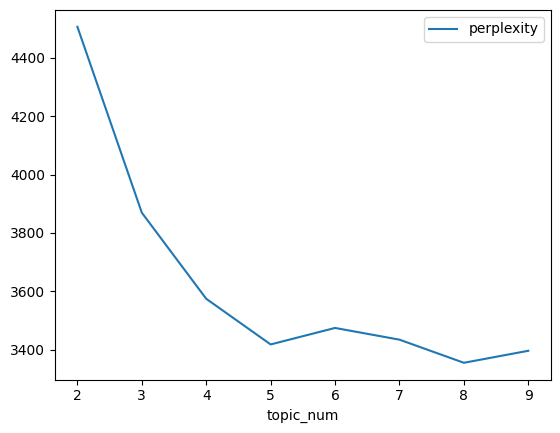

In [136]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

2024-05-03 21:53:36,826 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,827 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,827 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,828 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,829 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,830 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,831 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

2024-05-03 21:53:36,834 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,836 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,837 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,839 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,840 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,841 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 21:53:36,843 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

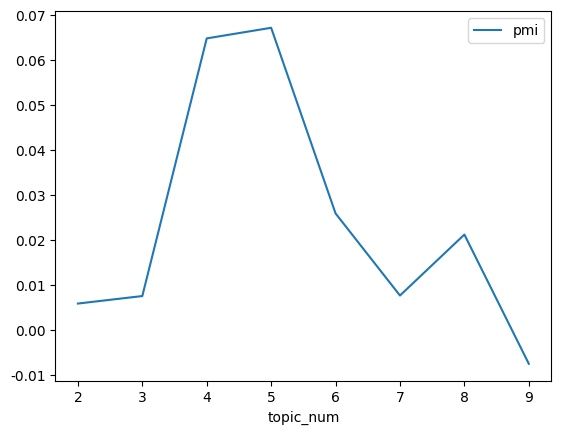

In [137]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 5 之後都不錯，coherence 最高則是 5

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 8 來做 LDAvis 的結果範例

In [184]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-03 22:33:18,571 : INFO : using symmetric alpha at 0.2
2024-05-03 22:33:18,572 : INFO : using symmetric eta at 0.2
2024-05-03 22:33:18,574 : INFO : using serial LDA version on this node
2024-05-03 22:33:18,582 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 3928 documents, updating model once every 2000 documents, evaluating perplexity every 3928 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-03 22:33:18,583 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-03 22:33:18,584 : INFO : PROGRESS: pass 0, at document #2000/3928
2024-05-03 22:33:19,391 : INFO : merging changes from 2000 documents into a model of 3928 documents
2024-05-03 22:33:19,394 : INFO : topic #0 (0.200): 0.005*"美國" + 0.004*"拜登" + 0.003*"指數" + 0.003*"報導" + 0.003*"總統" + 0.003*"中國" + 0.002*"包括" + 0.002*"公司" + 0.002*"國家" + 0.002*"認為"
2024-05-03 22:33:1

In [185]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

c:\Users\USER\miniconda3\envs\SMA_new\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.257682  0.141968       1        1  30.041844
3     -0.036857 -0.129586       2        1  20.026703
4      0.214439  0.122798       3        1  17.206224
1      0.139724 -0.012974       4        1  16.582764
2     -0.059625 -0.122206       5        1  16.142466, topic_info=      Term         Freq        Total Category  logprob  loglift
4264    億元  2704.000000  2704.000000  Default  30.0000  30.0000
10385   營收  1651.000000  1651.000000  Default  29.0000  29.0000
86      市場  1829.000000  1829.000000  Default  28.0000  28.0000
368     美國  2565.000000  2565.000000  Default  27.0000  27.0000
6093    男子  1182.000000  1182.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
214     表現   229.012226  1151.749262   Topic5  -6.0444   0.2085
693     攝影   180.384619   357.226137   Topic5  -6.2831   1.1404
242     過去   187.680684   561.854518   Topic5  -6.2435   0.7272
734     許多   181.005394   502.029392   Topic5  -6.2797   0.8036
2493    公司   189.772563  1833.927578   Topic5  -6.2324  -0.4447

[384 rows x 6 columns], token_table=       Topic      Freq Term
term                       
5          2  0.009540  三分球
5          5  0.982619  三分球
8700       1  0.979579   上漲
8700       2  0.013922   上漲
8700       3  0.002531   上漲
...      ...       ...  ...
12153      4  0.907808   高院
4222       3  0.017405  鳥山明
4222       5  0.974666  鳥山明
7654       2  0.968593   齋戒
7654       4  0.015134   齋戒

[1128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 3])

可以看到(7,8)、(3,6)和(2,5)很相近，試試看跑5個主題

In [187]:
model_4 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
p

2024-05-03 22:35:11,811 : INFO : using symmetric alpha at 0.25
2024-05-03 22:35:11,813 : INFO : using symmetric eta at 0.25
2024-05-03 22:35:11,817 : INFO : using serial LDA version on this node
2024-05-03 22:35:11,822 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 3928 documents, updating model once every 2000 documents, evaluating perplexity every 3928 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-03 22:35:11,822 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-03 22:35:11,823 : INFO : PROGRESS: pass 0, at document #2000/3928
2024-05-03 22:35:12,578 : INFO : merging changes from 2000 documents into a model of 3928 documents
2024-05-03 22:35:12,580 : INFO : topic #0 (0.250): 0.006*"美國" + 0.005*"拜登" + 0.003*"中國" + 0.003*"指數" + 0.003*"總統" + 0.003*"報導" + 0.002*"川普" + 0.002*"國家" + 0.002*"包括" + 0.002*"美元"
2024-05-03 22:35

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.256332  0.078347       1        1  30.295032
1      0.198856  0.130168       2        1  27.182028
3      0.022964 -0.120760       3        1  24.335239
2      0.034511 -0.087756       4        1  18.187700, topic_info=      Term         Freq        Total Category  logprob  loglift
4264    億元  2680.000000  2680.000000  Default  30.0000  30.0000
10385   營收  1636.000000  1636.000000  Default  29.0000  29.0000
86      市場  1817.000000  1817.000000  Default  28.0000  28.0000
368     美國  2622.000000  2622.000000  Default  27.0000  27.0000
3677    指數  1142.000000  1142.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
242     過去   190.134215   558.084234   Topic4  -6.3498   0.6276
2493    公司   204.641852  1812.840165   Topic4  -6.2763  -0.4770
149     未來   189.614045   765.967059   Topic4  -6.3525   0.3083
368     美國   198.520130  2622.960948   Topic4  -6.3066  -0.8767
124     提供   189.266746  1094.901880   Topic4  -6.3544  -0.0508

[311 rows x 6 columns], token_table=       Topic      Freq Term
term                       
12980      2  0.988252   一審
12980      3  0.007782   一審
5          3  0.009930  三分球
5          4  0.983090  三分球
8700       1  0.980344   上漲
...      ...       ...  ...
4222       3  0.008994  鳥山明
4222       4  0.980349  鳥山明
7654       2  0.014983   齋戒
7654       3  0.973890   齋戒
7654       4  0.014983   齋戒

[859 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [188]:
model_6 = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_6, corpus, dictionary)
p

2024-05-03 22:35:42,441 : INFO : using symmetric alpha at 0.16666666666666666
2024-05-03 22:35:42,442 : INFO : using symmetric eta at 0.16666666666666666
2024-05-03 22:35:42,445 : INFO : using serial LDA version on this node
2024-05-03 22:35:42,452 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 3928 documents, updating model once every 2000 documents, evaluating perplexity every 3928 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-03 22:35:42,453 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-03 22:35:42,454 : INFO : PROGRESS: pass 0, at document #2000/3928
2024-05-03 22:35:43,266 : INFO : merging changes from 2000 documents into a model of 3928 documents
2024-05-03 22:35:43,269 : INFO : topic #0 (0.167): 0.005*"美國" + 0.004*"指數" + 0.004*"拜登" + 0.003*"中國" + 0.003*"報導" + 0.003*"總統" + 0.002*"包括" + 0.002*"公司" + 0.002*"美元"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.255133 -0.152208       1        1  26.391368
5      0.012936  0.205634       2        1  20.777310
4     -0.242090 -0.127746       3        1  16.209185
1     -0.154095 -0.000419       4        1  14.173878
3      0.067771  0.090574       5        1  12.776704
2      0.060345 -0.015835       6        1   9.671555, topic_info=      Term         Freq        Total Category  logprob  loglift
4264    億元  2613.000000  2613.000000  Default  30.0000  30.0000
1727    中國  1486.000000  1486.000000  Default  29.0000  29.0000
10385   營收  1593.000000  1593.000000  Default  28.0000  28.0000
2493    公司  1878.000000  1878.000000  Default  27.0000  27.0000
6093    男子  1194.000000  1194.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
1712    進行   129.251493   889.896948   Topic6  -6.1042   0.4066
1178    相關   128.967974  1050.399454   Topic6  -6.1064   0.2386
1727    中國   135.125087  1486.485811   Topic6  -6.0598  -0.0620
368     美國   134.820912  2556.109138   Topic6  -6.0620  -0.6063
4900    產品   118.622243   689.255157   Topic6  -6.1900   0.5763

[484 rows x 6 columns], token_table=       Topic      Freq Term
term                       
12980      3  0.122306   一審
12980      4  0.870529   一審
14041      1  0.032270   丁丁
14041      6  0.935827   丁丁
4206       2  0.981303  七龍珠
...      ...       ...  ...
12153      3  0.012300   高院
12153      4  0.971666   高院
4222       2  0.987631  鳥山明
11709      4  0.959059  麥康諾
7654       2  0.981027   齋戒

[1504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 2, 4, 3])

替換主題數跑看看，可以看出最佳參數的數字和人類判斷的不一定會相符，所以為了更好的觀察文本中的資訊，逐步、循環的調整是很重要的

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [144]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [145]:
import guidedlda

In [146]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一員', '一場', '一環', '一直', '一股', '三分球', '上半場', '上旬', '下一場', '下來')

In [147]:
word2id = dictionary.token2id

In [148]:
seed_topic_list = [
    ["億元", "市場", "營收", "指數", "投資"],
    ["記者", "調查", "毒品", "分局", "檢方"],
    ["美國", "中國", "拜登", "以色列", "日本"],
    ["比賽", "球隊", "選手", "賽事", "棒球"]
]

In [149]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [150]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [153]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-03 22:13:27,046 : INFO : n_documents: 3928
2024-05-03 22:13:27,046 : INFO : vocab_size: 14057
2024-05-03 22:13:27,047 : INFO : n_words: 598356


2024-05-03 22:13:27,048 : INFO : n_topics: 6
2024-05-03 22:13:27,048 : INFO : n_iter: 100
2024-05-03 22:13:28,953 : INFO : <0> log likelihood: -6587411
2024-05-03 22:13:29,376 : INFO : <20> log likelihood: -5018400
2024-05-03 22:13:29,779 : INFO : <40> log likelihood: -4987766
2024-05-03 22:13:30,193 : INFO : <60> log likelihood: -4976311
2024-05-03 22:13:30,596 : INFO : <80> log likelihood: -4971071
2024-05-03 22:13:30,995 : INFO : <99> log likelihood: -4967658


In [154]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 億元 市場 營收 成長 指數 持續 台股 表現 預期 上漲
Topic 1: 男子 記者 分局 毒品 調查 檢方 駕駛 造成 員警 翻攝
Topic 2: 美國 拜登 總統 以色列 報導 中國 川普 加薩 國家 烏克蘭
Topic 3: 比賽 台灣 聯盟 球隊 巨人 球員 選手 台北 讀賣 球迷
Topic 4: 公司 日本 中國 政府 提供 台灣 全球 進行 投資 經濟
Topic 5: 萬元 認為 年月日 法官 法院 起訴 網友 當時 女子 工作


c:\Users\USER\miniconda3\envs\SMA_new\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.246295  0.197247       1        1  26.327479
1      0.330907  0.198802       2        1  17.084038
4     -0.125482  0.046336       3        1  15.839267
2     -0.012032 -0.183233       4        1  15.209201
5      0.113199 -0.168421       5        1  13.674368
3     -0.060298 -0.090731       6        1  11.865648, topic_info=      Term         Freq        Total Category  logprob  loglift
4264    億元  2548.000000  2548.000000  Default  30.0000  30.0000
368     美國  2681.000000  2681.000000  Default  29.0000  29.0000
5589    拜登  1221.000000  1221.000000  Default  28.0000  28.0000
10385   營收  1556.000000  1556.000000  Default  27.0000  27.0000
86      市場  1877.000000  1877.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
693     攝影   196.645079   400.407634   Topic6  -5.8890   1.4204
601     運動   186.663602   332.538643   Topic6  -5.9411   1.5541
853     希望   198.641375   702.947345   Topic6  -5.8789   0.8677
141     時間   195.646931   775.898401   Topic6  -5.8941   0.7538
771     世界   179.676568   338.506319   Topic6  -5.9793   1.4981

[381 rows x 6 columns], token_table=       Topic      Freq Term
term                       
12980      5  1.001110   一審
3564       5  1.000837   丈夫
8700       1  0.999829   上漲
6422       4  0.012114   上訴
6422       5  0.989269   上訴
...      ...       ...  ...
6938       4  1.000945   飛彈
8522       1  0.018542   駕駛
8522       2  0.968319   駕駛
8522       5  0.012362   駕駛
12396      5  1.000848  高虹安

[692 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 6, 4])

In [225]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-03 22:39:55,935 : INFO : n_documents: 3928
2024-05-03 22:39:55,936 : INFO : vocab_size: 14057
2024-05-03 22:39:55,937 : INFO : n_words: 598356
2024-05-03 22:39:55,937 : INFO : n_topics: 5
2024-05-03 22:39:55,938 : INFO : n_iter: 100
2024-05-03 22:39:57,788 : INFO : <0> log likelihood: -6429934
2024-05-03 22:39:58,188 : INFO : <20> log likelihood: -4998940
2024-05-03 22:39:58,576 : INFO : <40> log likelihood: -4974156
2024-05-03 22:39:58,960 : INFO : <60> log likelihood: -4967736
2024-05-03 22:39:59,339 : INFO : <80> log likelihood: -4964356
2024-05-03 22:39:59,715 : INFO : <99> log likelihood: -4963411


In [226]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 億元 市場 營收 成長 指數 持續 投資 公司 台股 表現
Topic 1: 男子 記者 分局 毒品 調查 駕駛 檢方 造成 員警 翻攝
Topic 2: 美國 拜登 中國 總統 報導 以色列 國家 川普 加薩 支持
Topic 3: 比賽 台灣 聯盟 球隊 巨人 球員 選手 台北 讀賣 球迷
Topic 4: 公司 日本 認為 萬元 提供 台灣 透過 是否 政府 使用


c:\Users\USER\miniconda3\envs\SMA_new\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.202673 -0.128678       1        1  29.451469
4      0.024588 -0.058005       2        1  21.595105
1     -0.371213 -0.012844       3        1  18.786365
2      0.052424 -0.114460       4        1  18.109933
3      0.091528  0.313987       5        1  12.057128, topic_info=      Term         Freq        Total Category  logprob  loglift
368     美國  2681.000000  2681.000000  Default  30.0000  30.0000
4264    億元  2548.000000  2548.000000  Default  29.0000  29.0000
86      市場  1877.000000  1877.000000  Default  28.0000  28.0000
5589    拜登  1221.000000  1221.000000  Default  27.0000  27.0000
10385   營收  1556.000000  1556.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
771     世界   190.674285   338.546906   Topic5  -5.9359   1.5414
693     攝影   193.669012   400.452349   Topic5  -5.9203   1.3891
601     運動   187.679558   332.571938   Topic5  -5.9517   1.5434
853     希望   198.660224   703.135731   Topic5  -5.8948   0.8516
141     時間   198.660224   776.061030   Topic5  -5.8948   0.7529

[315 rows x 6 columns], token_table=      Topic      Freq Term
term                      
4979      1  1.000770   上市
8700      1  0.999695   上漲
771       1  0.115198   世界
771       4  0.321964   世界
771       5  0.564176   世界
...     ...       ...  ...
1595      4  0.028194   預期
1595      5  0.031448   預期
8522      1  0.020600   駕駛
8522      3  0.978478   駕駛
4222      2  1.000705  鳥山明

[542 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 4])

In [229]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-03 22:40:51,803 : INFO : n_documents: 3928
2024-05-03 22:40:51,803 : INFO : vocab_size: 14057
2024-05-03 22:40:51,805 : INFO : n_words: 598356
2024-05-03 22:40:51,806 : INFO : n_topics: 4
2024-05-03 22:40:51,806 : INFO : n_iter: 100
2024-05-03 22:40:53,572 : INFO : <0> log likelihood: -6243861
2024-05-03 22:40:53,913 : INFO : <20> log likelihood: -4995593
2024-05-03 22:40:54,249 : INFO : <40> log likelihood: -4978436
2024-05-03 22:40:54,579 : INFO : <60> log likelihood: -4972290
2024-05-03 22:40:54,906 : INFO : <80> log likelihood: -4969261
2024-05-03 22:40:55,235 : INFO : <99> log likelihood: -4966657


In [230]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 億元 市場 營收 成長 公司 指數 投資 持續 台股 表現
Topic 1: 男子 萬元 記者 分局 調查 毒品 造成 駕駛 檢方 員警
Topic 2: 美國 拜登 報導 中國 總統 以色列 國家 川普 加薩 政府
Topic 3: 台灣 比賽 日本 聯盟 球隊 巨人 台北 球員 選手 讀賣


c:\Users\USER\miniconda3\envs\SMA_new\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.254192  0.159534       1        1  30.762782
1      0.288092  0.107281       2        1  26.738273
2      0.000642  0.012207       3        1  26.256776
3     -0.034541 -0.279022       4        1  16.242170, topic_info=      Term         Freq        Total Category  logprob  loglift
4264    億元  2548.000000  2548.000000  Default  30.0000  30.0000
86      市場  1877.000000  1877.000000  Default  29.0000  29.0000
368     美國  2682.000000  2682.000000  Default  28.0000  28.0000
10385   營收  1556.000000  1556.000000  Default  27.0000  27.0000
5589    拜登  1221.000000  1221.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
693     攝影   216.723284   400.587211   Topic4  -6.1058   1.2032
586     記者   277.642690  1038.987399   Topic4  -5.8580   0.4979
214     表現   284.633441  1151.944318   Topic4  -5.8332   0.4196
1712    進行   236.696859   943.113648   Topic4  -6.0176   0.4352
242     過去   217.721962   588.435217   Topic4  -6.1012   0.8233

[249 rows x 6 columns], token_table=      Topic      Freq Term
term                      
4979      1  1.000706   上市
8700      1  0.999612   上漲
3905      1  1.000709   下跌
771       1  0.082681   世界
771       3  0.295289   世界
...     ...       ...  ...
1595      1  0.936830   預期
1595      3  0.030360   預期
1595      4  0.032529   預期
8522      1  0.018534   駕駛
8522      2  0.982286   駕駛

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [62]:
# udn.loc[udn['artCatagory']=='兩岸', "content"].to_csv("tmp.csv")
udn.loc[udn['artCatagory']=='兩岸', "words"].to_csv("words.csv")
udn.loc[udn['artCatagory']=='股市', "words"].to_csv("words_stock.csv")


In [63]:
udn.loc[udn['artCatagory']=='兩岸', "words"].explode().value_counts().to_csv("words_count.csv")
udn.loc[udn['artCatagory']=='股市', "words"].explode().value_counts().to_csv("words_count_stock.csv")

## 7. 主題分佈的應用，搭配其他文章資訊

In [232]:
# 取得每條新聞的主題分佈
topics_doc = model_4.get_document_topics(corpus)

In [233]:
topics_doc[100]

[(2, 0.99466497)]

In [234]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.01642059, 0.        , 0.98214138, 0.        ],
       [0.        , 0.        , 0.99698448, 0.        ],
       [0.        , 0.        , 0.99822414, 0.        ],
       ...,
       [0.99563766, 0.        , 0.        , 0.        ],
       [0.99375606, 0.        , 0.        , 0.        ],
       [0.928536  , 0.        , 0.        , 0.067456  ]])

In [235]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [236]:
udn['topic_label'].value_counts()

1    1283
2    1097
4     834
3     714
Name: topic_label, dtype: int64

In [237]:
filtered_df = udn[udn['topic_label'] == 1]
print(filtered_df.head(5))

                                                content  \
815   台積電熊本廠開始營運朝日新聞報導日本從政府到企業從交通到教育全力為新湧入的外籍人士作好準備熊...   
900   南韓記憶體大廠海力士正大舉支出投入先進晶片封裝希望能抓住市場對高頻寬記憶體這種發展重要零組件...   
901   南韓電池廠三星周三日表示將在年開始量產用於電動車和其他應用的固態電池日經新聞報導在首爾舉行的...   
1033  上個月當比特幣逼近美元價位時摩根大通執行長戴蒙將這種加密貨幣比喻為寵物石年代中期的一種瘋狂的...   
1034  個人電腦大廠惠普上季營收下滑不過減幅連續第三季收斂被視為市場趨穩今年將恢復成長的跡象但消費者...   

                                       artUrl artCatagory             artDate  \
815   https://udn.com/news/story/6809/7809842          國際 2024-03-05 13:50:00   
900   https://udn.com/news/story/6809/7814486          國際 2024-03-07 10:55:00   
901   https://udn.com/news/story/6809/7814568          國際 2024-03-07 11:21:00   
1033  https://udn.com/news/story/6811/7800912          國際 2024-03-01 07:26:00   
1034  https://udn.com/news/story/6811/7801002          國際 2024-03-01 03:05:00   

                                                  words  topic_label  
815   [台積電, 熊本, 營運, 朝日, 新聞報導, 日本, 從政, 企業, 交通, 教育, 湧入...            1  
900   [南韓, 記憶體, 

In [238]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,湯普森近期連續五場球被勇士教練團降為替補這也是他打從新人年以來首度從板凳出發據統計湯普森此前...,https://udn.com/news/story/122629/7801017,體育,2024-03-01 07:00:00,"[湯普森, 近期, 連續, 五場, 勇士, 教練, 團降, 替補, 這也, 新人, 以來, ...",3
1,剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接官辦熱身賽為年例行賽之前做最後備戰巨人軍想要...,https://udn.com/news/story/122629/7806019,體育,2024-03-04 07:00:00,"[剛打, 完台灣, 遠征, 比賽, 讀賣, 巨人, 返回, 日本, 之後, 準備, 迎接, ...",3
2,誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長基特不過基特其實是在年過的生涯第個球季...,https://udn.com/news/story/122629/7806063,體育,2024-03-04 07:00:00,"[洋基隊, 史上, 偉大, 開路先鋒, 想到, 隊長, 基特, 基特, 年過, 生涯, 第個...",3
3,近期媒體報導樂天桃猿教練團計畫將先發投手曾仁和轉調牛棚陳冠宇自請重回先發老實說這樣的安排風險...,https://udn.com/news/story/122629/7806105,體育,2024-03-04 07:00:00,"[近期, 媒體, 報導, 樂天, 桃猿, 教練, 團計, 畫將, 先發, 投手, 仁和, 轉...",3
4,撰文石毓琪四年前職業棒球雜誌於球春到來開季春訓特輯封面放上時任隊總教練快轉個球季只剩下近年摘...,https://udn.com/news/story/122629/7808048,體育,2024-03-06 12:00:00,"[撰文, 石毓琪, 四年, 職業, 棒球, 雜誌, 球春, 到來, 開季, 春訓, 特輯, ...",3


In [239]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [240]:
udn['artDate'].dt.date

0       2024-03-01
1       2024-03-04
2       2024-03-04
3       2024-03-04
4       2024-03-06
           ...    
5234    2024-03-10
5235    2024-03-10
5236    2024-03-10
5237    2024-03-10
5238    2024-03-10
Name: artDate, Length: 3928, dtype: object

In [241]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-03-01  1              0.334792
            2              0.315098
            3              0.185996
            4              0.164114
2024-03-02  2              0.344398
            3              0.307054
            4              0.236515
            1              0.112033
2024-03-03  3              0.279141
            2              0.273006
            4              0.263804
            1              0.184049
2024-03-04  1              0.310881
            2              0.292746
            4              0.238342
            3              0.158031
2024-03-05  1              0.371365
            2              0.270694
            4              0.214765
            3              0.143177
2024-03-06  1              0.393701
            2              0.283465
            4              0.194882
            3              0.127953
2024-03-07  1              0.368914
            2              0.273408
            4              0.192884
    

In [242]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4
artDate,,,,
2024-03-01,0.334792,0.315098,0.185996,0.164114
2024-03-02,0.112033,0.344398,0.307054,0.236515
2024-03-03,0.184049,0.273006,0.279141,0.263804
2024-03-04,0.310881,0.292746,0.158031,0.238342
2024-03-05,0.371365,0.270694,0.143177,0.214765


2024-05-03 22:42:04,954 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 22:42:04,955 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 22:42:04,956 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 22:42:04,957 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 22:42:04,959 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 22:42:04,960 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-05-03 22:42:04,962 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

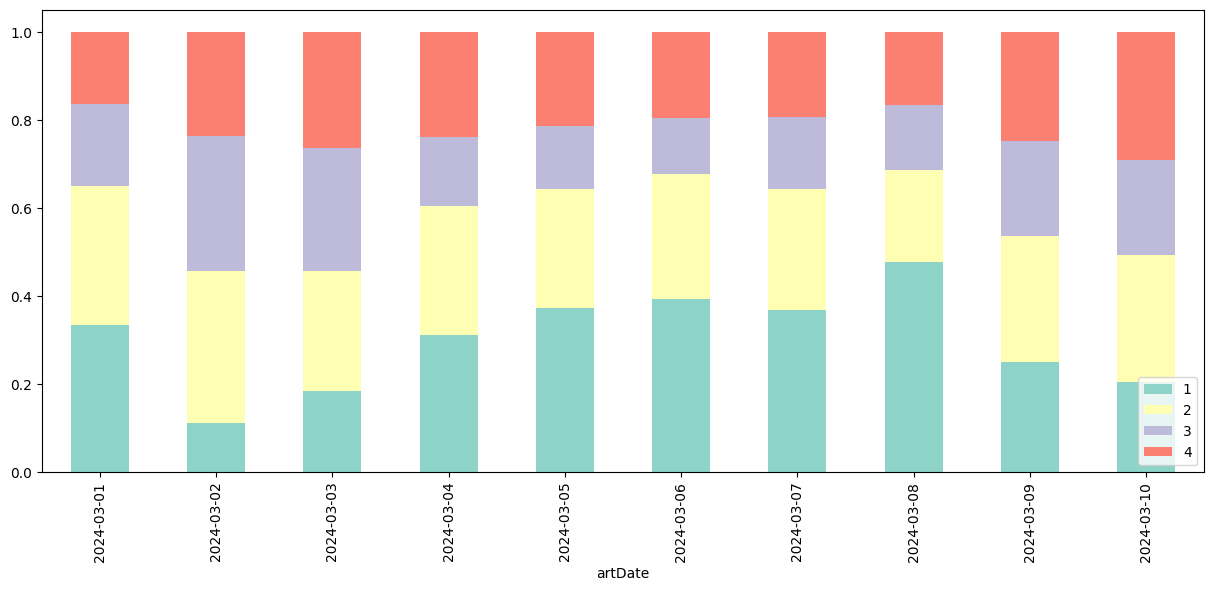

In [243]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題3（中國各產業市場）在 2/15、2/16 被討論的比例很高，可以作為後續探索的目標，<br>
大家可以像這樣，透過搭配文章的資訊（例如日期等），讓主題模型的結果做出更多的分析應用。